### Common utilities

Copied from 2019

In [444]:
import requests
import logging
import re
from functools import lru_cache
from itertools import permutations, combinations, chain, cycle, product, islice
import networkx as nx
import collections
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy
import os
from aocd import get_data, submit

# get your session token from chrome devtools and paste it into a file
session_token = open('session_cookie.txt').read().strip()
os.environ["AOC_SESSION"] = session_token

logger = logging.getLogger()
logger.setLevel(level=logging.INFO)

## input fetching
@lru_cache()
def get_input(day, year=2020):
    url = 'http://adventofcode.com/%d/day/%d/input' % (year, day)
    logging.info('fetching %s', url)
    r = requests.get(url, cookies={
        'session': session_token
    })
    if r.status_code != 200:
        print(r.content)
        return None
    logging.info('Fetched %d bytes of input', len(r.content))
    return r.content.rstrip()

def try_convert(val, convert_fn):
    if convert_fn is None:
        return val
    try:
        val = convert_fn(val)
    except Exception as e:
        #logging.exception(e)
        pass
    return val

def input_lines(day, year=2020, delim=None, strip=True, convert_fn=int):
    data = get_input(day, year)
    for line in data.decode('ascii').split('\n'):
        if strip:
            line = line.strip()
        if delim:
            chunks = re.split(delim, line)
            chunks = [try_convert(chunk, convert_fn) for chunk in chunks]
            yield chunks
        else:
            line = try_convert(line, convert_fn)
            yield line

# def submit_day(day, part, answer, year=2020):
#     url = 'https://adventofcode.com/%d/day/%d/answer' % (year, day)
#     r = requests.post(url, cookies={
#         'session': session_token
#     }, data='level=%d&answer=%s' % (part, answer))
#     return r

def get_ready():
    d = get_data(block=True)
    print(d)
    return d
        
## general utils
# a default dict that passes the key to the default_factory
class keydefaultdict(collections.defaultdict):
    def __missing__(self, key):
        if self.default_factory is None:
            raise KeyError(key)
        else:
            ret = self[key] = self.default_factory(key)
            return ret

## plotting tools
# plot an iterable of (x, y)
def plot_xy_list(it):
    coords = np.array(list(it))
    origin = np.min(coords, axis=0)
    coords -= origin
    grid = np.full(np.max(coords, axis=0) + 1, 0)
    grid[tuple(coords.T)] = 1
    plt.imshow(grid.T)
    
def nx_draw(G):
    layout = nx.circular_layout(G)
    nx.draw(G, pos=layout, with_labels=True, node_color='#ffdddd')
    plt.show()

class Direction(object):
    N = 0
    E = 1
    S = 2
    W = 3
    NE = 4
    SE = 5
    SW = 6
    NW = 7
    DIRS = [
        (0, -1),
        (1, 0),
        (0, 1),
        (-1, 0),
        (1, -1),
        (1, 1),
        (-1, 1),
        (-1, -1)
    ]
    @staticmethod
    def from_string(s):
        return ['N', 'E', 'S', 'W', 'NE', 'SE', 'SW', 'NW'].index(s)
    
class Marker(object):
    def __init__(self, pos, facing=Direction.N):
        self.pos = pos
        self.facing = facing
    def relative_pos(self, direction, units=1):
        delta = Direction.DIRS[direction]
        return (self.pos[0] + delta[0] * units, self.pos[1] + delta[1] * units)
    def move(self, direction=None, units=1):
        if direction is None:
            direction = self.facing
        self.pos = self.relative_pos(direction, units)
        return self.pos
    def turn_left(self):
        self.facing -= 1
        self.facing %= 4
    def turn_right(self):
        self.facing += 1
        self.facing %= 4
    def adjacent(self):
        return [self.relative_pos(d) for d in range(4)]
    def adjdiag(self):
        for dx, dy in Direction.DIRS:
            yield (self.pos[0] + dx, self.pos[1] + dy)

    
class Field(object):
    def __init__(self, data, force_width=None):
        try:
            self.field = data.split('\n')
        except:
            self.field = data.decode('ascii').split('\n')
        if force_width:
            self.width = force_width
        else:
            self.width = len(self.field[0])        
        self.field = [ r + ' ' * (self.width - len(r)) for r in self.field ]
        self.field = [ list(r) for r in self.field ]
        self.height = len(self.field)
        self.markers = []
        
    def clone(self):
        f = Field('')
        f.field = copy.deepcopy(self.field)
        f.width = self.width
        f.height = self.height
        # TODO markers
        return f
    
    def dump(self):
        print(self.raw)
    
    @staticmethod
    def from_day(day):
        return Field(get_input(day))
    
    @staticmethod
    def from_numpy(arr):
        f = Field('')
        f.field = arr.tolist()
        f.width = len(f.field[0])
        f.height = len(f.field)
        return f
        
    @property
    def raw(self):
        return '\n'.join(''.join([str(c) for c in r]) for r in self.field)
        
    def add_marker(self, marker):
        self.markers.append(marker)
        
    def get(self, x, y, oob_none=False):
        if x < 0 or y < 0 or x >= self.width or y >= self.height:
            if oob_none:
                return None
            raise KeyError('(%d:%d): out of bounds! [%dx%d]' % (x, y, self.width, self.height))
        return self.field[y][x]
    
    def set(self, x, y, v):
        self.field[y][x] = v
    
    def find(self, v):
        for y in range(self.height):
            for x in range(self.width):
                if self.get(x, y) == v:
                    yield (x, y)

    def iterate(self):
        for y in range(self.height):
            for x in range(self.width):
                yield (x, y), self.get(x, y)
                
    def iterate_marker(self):
        for y in range(self.height):
            for x in range(self.width):
                yield Marker((x, y))
                
    @property
    def numpy(self):
        return np.array(self.field)
    
    @property
    def df(self):
        return pd.DataFrame(self.numpy)
    
    def plot(self, key_fn=None):        
        if key_fn is None:
            mapping = { v: i for (i, v) in enumerate(np.unique(self.numpy)) }
            key_fn = lambda x: mapping[x]
            logging.info('Using default key_fn: %s', mapping)
        mapped = np.vectorize(key_fn)(self.numpy)
        if len(self.markers) > 0:
            marker_key = np.max(mapped) + 1
            for m in self.markers:
                mapped[m.pos[1]][m.pos[0]] = marker_key
                marker_key += 1            
        plt.imshow(mapped)
        
    def nx_maze(self, is_wall_fn=lambda t: t == '#'):
        G = nx.grid_2d_graph(f.width, f.height)
        for pos, t in self.iterate():
            if is_wall_fn(t):
                G.remove_node(pos)
        return G
    
# consider implementing a generalised dijkstras algorithm where you only need to implement
# (i) a State object that is hashable
# (ii) a get_next_states(priority, state) function that returns another list of (priority, state)
# (iii) a is_solved(state) function that returns boolean
# and run with solve(initial_state) to return lowest 
from queue import PriorityQueue
from dataclasses import dataclass, field as dcfield
from typing import Any, Callable, Generator

@dataclass(order=True)
class PrioritizedState:
    distance: int
    state: Any=dcfield(compare=False)
    def __hash__(self):
        return hash(self.state)

def dijkstra(initial_state: PrioritizedState, 
             get_next: Callable[[PrioritizedState], Generator[PrioritizedState, None, None]], 
             is_solved: Callable[[PrioritizedState], bool]) -> Generator[PrioritizedState, None, None]:
    queue = PriorityQueue()
    visited = set()
    queue.put(PrioritizedState(0, initial_state))
    
    while True:
        if queue.empty():
            logging.warning('no more states to try')
            break
        ps = queue.get()
        if ps in visited:
            continue
        visited.add(ps)
        if is_solved(ps):
            logging.info('solution found after visitng %d', len(visited))
            yield ps
        for ns in get_next(ps):
            queue.put(ns)

INFO:root:Using default key_fn: {' ': 0, '#': 1, 'E': 2, 'S': 3}


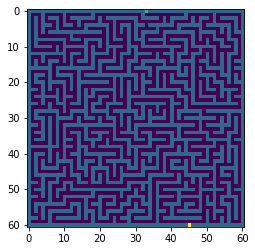

In [16]:
## consider the simple BFS of a maze
from mazelib import Maze
from mazelib.generate.AldousBroder import AldousBroder
m = Maze()
m.generator = AldousBroder(30, 30)
m.generate()
m.generate_entrances()
f = Field(m.tostring(True))
f.plot()

In [291]:
np.array([[1,2,3],[2,3,4]]).tolist()

[[1, 2, 3], [2, 3, 4]]

INFO:root:solution found after visitng 49713
INFO:root:Using default key_fn: {' ': 0, '#': 1, '*': 2, 'E': 3, 'S': 4}


CPU times: user 3.89 s, sys: 52.4 ms, total: 3.94 s
Wall time: 3.94 s


212

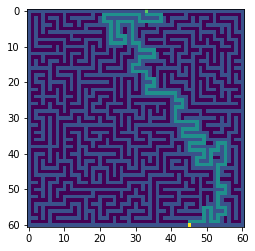

In [17]:
%%time
start = next(f.find('S'))
goal = next(f.find('E'))

## the state is just the position of the robot
@dataclass
class State:
    position: tuple
    path: list
    def __hash__(self):
        return hash(self.position)

## get_next returns all the adjacent positions which are not walls
def get_next(p: PrioritizedState):
    m = Marker(p.state.position)
    for a in m.adjacent():
        try:
            if f.get(*a) != '#':
                path = p.state.path[:]
                path.append(a)
                yield PrioritizedState(1 + p.distance, State(a, path))
        except KeyError:
            pass
        
## get solved state is if position is at goal
def is_solved(p: PrioritizedState):
    return p.state.position == goal

solution = next(dijkstra(State(start, []), get_next, is_solved))
for p in solution.state.path:
    if p != goal:
        f.set(*p, '*')
    
f.plot()
solution.distance

## Day 1: the 503 fiasco

In [94]:
%%time
from itertools import combinations
import numpy as np

# part 1
print([np.prod(nums) for nums in combinations(input_lines(1), 2) if sum(nums) == 2020])

# part 2
print([np.prod(nums) for nums in combinations(input_lines(1), 3) if sum(nums) == 2020])

INFO:root:fetching http://adventofcode.com/2020/day/1/input
INFO:root:Fetched 996 bytes of input


[1020084]
[295086480]
CPU times: user 246 ms, sys: 30.4 ms, total: 277 ms
Wall time: 1.67 s


## Day 2: password validation

I made a mistake in my code where I was counting the whole string instead of the password :(

In [188]:
import re
from collections import Counter

def is_valid_part1(line):
    minn, maxx, let, pwd = re.match('^(\d+)-(\d+) (.): (\w+)', line).groups()
    minn = int(minn)
    maxx = int(maxx)
    letters = Counter(list(pwd))
    count = letters[let]
    return count >= minn and count <= maxx

def is_valid_part2(line):
    minn, maxx, let, pwd = re.match('^(\d+)-(\d+) (.): (\w+)', line).groups()
    minn = int(minn)
    maxx = int(maxx)
    letters = list(pwd)
    return bool(letters[minn-1] == let) ^ bool(letters[maxx-1] == let)

print(sum([1 for l in input_lines(2) if is_valid_part1(l)]))
print(sum([1 for l in input_lines(2) if is_valid_part2(l)]))

454
649


## Day 3

I tried to be too fancy to derive the column based on the row and made part 2 a lot harder.

In [201]:
f = Field.from_day(3)
def count_trees(dx, dy=1):
    count = 0
    y = 0
    x = 0
    while y < rows:
        t = f.get(x, y)
        y += dy
        x += dx
        x %= cols
        if t == '#':
            count += 1
    return count

# part 1
print(count_trees(3))

# part 2
print(np.prod([count_trees(*args) for args in [(1, 1), (3, 1), (5, 1), (7, 1), (1, 2)]]))

INFO:root:fetching http://adventofcode.com/2020/day/3/input
INFO:root:Fetched 10336 bytes of input


270
2122848000


## Day 4

For some reason I thought `re.match` only returns a match if it matches the full string. As a result I was off-by-one in my part 2 solution for the longest time :(

Other learnings: you can do `min <= num <= max` as an expression.

Reminder: `all()` and `any()` exists for quick "reduce" functions.

In [297]:
curr = {}
passports = []
for l in input_lines(4):
    if l == '':
        passports.append(curr)
        curr = {}
    else:
        parts = l.split(' ')
        for k, v in [p.split(':') for p in parts]:
            if k != 'cid':
                curr[k] = v
passports.append(curr)
            
req = set(['byr', 'iyr', 'eyr', 'hgt', 'hcl', 'ecl', 'pid'])

def validate_part1(p):
    return set(p.keys()) == req

def validate_key(k, v):
    if k == 'byr':
        vv = int(v)
        return 1920 <= vv <= 2002
    elif k == 'iyr':
        vv = int(v)
        return 2010 <= vv <= 2020
    elif k == 'eyr':
        vv = int(v)
        return 2020 <= vv <= 2030
    elif k == 'hgt':
        m = re.match('^(\d+)(cm|in)$', v)
        if not m:
            return False
        val, unit = m.groups()
        vv = int(val)
        if unit == 'cm':
            return 150 <= vv <= 193
        else:
            return 59 <= vv <= 76
    elif k == 'hcl':
        m = re.match('^#[0-9a-f]{6}$', v)
        return m is not None
    elif k == 'ecl':
        return v in 'amb blu brn gry grn hzl oth'.split(' ')
    elif k == 'pid':
        m = re.match('^[0-9]{9}$', v)
        return m is not None        
    return False

def validate_part2(p):
    return validate_part1(p) and all([validate_key(k, v) for k, v in p.items()])
    
print(sum([1 for p in passports if validate_part1(p)]))
print(sum([1 for p in passports if validate_part2(p)]))

202
137


## Day 5

Saturday so I didn't get to look at the puzzle until 7.

I noticed that it's basically binary encoding if you map the F/B and L/R to 0/1.

In [328]:
map1 = {
    'B': 1,
    'F': 0,
}

map2 = {
    'L': 0,
    'R': 1,
}

def get_id(l):
    row = int(''.join([str(map1[c]) for c in list(l[:7])]), 2)
    col = int(''.join([str(map2[c]) for c in list(l[7:])]), 2)
    return row * 8 + col

ids = sorted([get_id(l) for l in input_lines(5)])

print(ids[-1])
for i, val in enumerate(ids):
    if val - ids[i + 1] != -1:
        print(val + 1)
        break

919
642


## Day 6

I was definitely slow with thinking through a relatively simple part 2

Trial using `aocd` instead of my own utilities

In [409]:
from collections import defaultdict, Counter
from aocd import get_data, submit

groups = get_data(day=6).split('\n\n')

# dumb initial approaches
# def part1(group):
#     answers = set()
#     for person in group.split('\n'):
#         answers = answers.union(set(list(person)))
#     return len(answers)
#
# def part2(group):
#     answers = defaultdict(int)
#     people = group.split('\n')
#     for person in people:
#         for answer in list(person):
#             answers[answer] += 1
#     return len([p for p in answers if answers[p] == len(people)])

# this assumes each "person" won't have a repeated answer
def part2(group):
    count = Counter(group)
    return len([p for p in count if count[p] == len(group.split('\n'))])

print(sum(len(set(g.replace('\n', ''))) for g in groups))
print(sum(part2(g) for g in groups))

INFO:aocd.get:most recent year=2020


6778
3406


In [ ]:
# can i think about optimising the solve process of a typical AoC problem?
# there is almost always 3 operations
# 1. split the input into chunks
# 2. do some calculation on each chunk (map)
# 3. reduce the results into a single answer
# can we think about some kind of split-map-reduce utility

## Day 7 bags in bags

Still very slow to think through simple problems :(

Should learn to get more comfortable with networkx API so I don't resort to doing it myself

In [553]:
from aocd import get_data

colors = {}
def parse_bag(line):
    m = re.match('^(\w+ \w+) bags contain (.+)$', l)
    if not m:
        raise Exception('bad line', l)
    color, bags = m.groups()
    contains = {}
    for bag in bags.split(','):
        mm = re.match('^ ?(\d+) (\w+ \w+) bag', bag)
        if not mm:
            assert bag == 'no other bags.'
        else:
            num, bcol = mm.groups()
            contains[bcol] = int(num)
    colors[color] = contains
    
for l in get_data(day=7).split('\n'):
    parse_bag(l)

def contains_gold(col):
    if col == 'shiny gold':
        return True
    return any(contains_gold(c) for c in colors[col])

# part 1
print(sum(contains_gold(c) for c in colors) - 1)

# part 2
def count_bags(col):
    if len(bags_info[col]) == 0:
        return 1
    else:
        return 1 + sum(count_bags(cc) * colors[col][cc] for cc in colors[col])

print(count_bags('shiny gold') - 1)

INFO:aocd.get:most recent year=2020


254
6006


## Day 8 IntCode again?!

Didn't start until 10mins in because of a meeting :(

In [554]:
from recordclass import RecordClass
from aocd import get_data

class Operation(RecordClass):
    op: str
    val: int    

class Program(object):
    def __init__(self, program):
        self.acc = 0
        self.ptr = 0
        self.instructions = self.parse_program(program)
    
    def next(self):
        ins = self.instructions[self.ptr]
        if ins.op == 'acc':
            self.acc += ins.val
            self.ptr += 1
        elif ins.op == 'jmp':
            self.ptr += ins.val
        elif ins.op == 'nop':
            self.ptr += 1
        
    def run(self):
        while True:
            try:
                self.next()
            except Exception as e:
#                 logger.info(e)
                return self.acc, False
            if self.ptr == len(self.instructions):
                logger.info('reached end of program')
                return self.acc, True
    
    def parse_program(self, program):
        prog = []
        for ins in program:
            m = re.match('(\w+) ([\+\-]\d+)', ins)
            op, val = m.groups()
            val = int(val)
            prog.append(Operation(op, val))
        return prog

class Day8(Program):
    def __init__(self, program):
        super(Day8, self).__init__(program)
        self.executed = set()
    def next(self):
        if self.ptr in self.executed:
            raise Exception('already executed, aborting')
        self.executed.add(self.ptr)
        super(Day8, self).next()

p = Day8(get_data(day=8).split('\n'))
acc, _ = p.run()
print(acc)

# part 2
for i, ins in enumerate(p.instructions):
    if ins.op == 'jmp':
        # try running the program with this set to nop
        new_prog = lines[:] # copy it
        new_prog[i] = lines[i].replace('jmp', 'nop')
        pp = Day8(new_prog)
        acc, ok = pp.run()
        if ok:
            print(acc)

INFO:aocd.get:most recent year=2020
INFO:root:reached end of program


1317
1033


## Day 9

Was in a retro for first half hour :( 

As a result I tried to skim instructions and missed that you were meant to return sum of smallest/largest number not first/last number in sequence.

A non-bruteforce idea would be to slide the window (grow tail if number to small, shrink head if number too large) until solution is achieved.

In [606]:
%%time
from aocd import lines
from itertools import combinations

nums = [int(n) for n in lines]

# part 1
# fugly 1 line solution
part1 = [n for i, n in enumerate(nums) if i >= 25 and n not in [a + b for a, b in combinations(nums[i-25:i], 2)]][0]
print(part1)
        
# part 2 brute force
# for small_idx, small_num in enumerate(nums):
#     for large_idx, large_num in enumerate(nums):
#         if small_idx < large_idx - 1:
#             num_seq = nums[small_idx:large_idx]
#             if sum(num_seq) == part1:
#                 print(min(num_seq) + max(num_seq))
#                 break
                
# even more fugly 1 line solution
part2 = [min(nums[i:j]) + max(nums[i:j]) for i, _ in enumerate(nums) for j, _ in enumerate(nums) if i < j - 1 and sum(nums[i:j]) == part1][0]
print(part2)

14360655
1962331
CPU times: user 1.88 s, sys: 3.87 ms, total: 1.89 s
Wall time: 1.89 s


## Day 10 Jolts

I foolishly tried to solve part 2 using math rather than DP and my brain exploded.

In [661]:
from aocd import lines
nums = [int(n) for n in lines]
adaptors = sorted(nums)
counter = defaultdict(int)
for i, a in enumerate(adaptors):
    if i > 0:
        counter[a - adaptors[i-1]] += 1
print(counter[1] * counter[3])

1782


In [671]:
# simple DP problem -- keep track of how many ways to go from 0 -> N
ways = defaultdict(int)
ways[0] = 1
for adaptor in adaptors:
    ways[adaptor] = sum([ways[adaptor - offset - 1] for offset in range(3) if adaptor - offset - 1 in ways])
ways[adaptors[-1]]        

14173478093824

## Day 11 SO MANY STUPID BUGS

So I had all these 1 character bugs... put `#` instead of `L`, put `d[0]` instead of `d[1]`

Maybe I am just too worn out from ShipIt... :(((

Also it's been a long time since I used my `Field` code and I hardly remember the interface

Also, this code is suuuper slow but I don't care any more

Reminder: `sum()` of a list of booleans is same as counting the `True`s

In [146]:
%%time
def occ_calc_part1(f, m):
    return sum(f.get(*p, oob_none=True) == '#' for p in m.adjdiag())

def occ_calc_part2(f, m):
    occ_count = 0
    for d in range(8):
        units = 0
        while True:            
            units += 1
            seat = f.get(*m.relative_pos(d, units), oob_none=True)
            if seat == '#':
                occ_count += 1
                break
            elif seat == 'L' or seat is None:
                break
    return occ_count                

def tick(f, occ_calc, limit=4):
    fnext = f.clone()
    changes = 0
    for m in f.iterate_marker():
        occ = occ_calc(f, m)
        seat = f.get(*m.pos)
        # If a seat is empty (L) and there are no occupied seats adjacent to it, the seat becomes occupied.
        if seat == 'L' and occ == 0:
            fnext.set(*m.pos, '#')
            changes += 1
        # If a seat is occupied (#) and four or more seats adjacent to it are also occupied, the seat becomes empty.
        if seat == '#' and occ >= limit:
            fnext.set(*m.pos, 'L')
            changes += 1
        # Otherwise, the seat's state does not change.
    return fnext, changes

def run(occ_calc, limit):
    f = Field(get_data())
    changes = -1
    while changes != 0:
        f, changes = tick(f, occ_calc, limit)
    print(sum(c == '#' for _, c in f.iterate()))
    
run(occ_calc_part1, 4)
run(occ_calc_part2, 5)

2270
2042
CPU times: user 13.8 s, sys: 20.3 ms, total: 13.8 s
Wall time: 13.9 s


## Day 12 boat moving

I didn't start until ~6pm as usual for Saturday.

Minor bugs with accidentally doing `% 90` instead of `/ 90` =_=

In [211]:
from aocd import lines
ferry = Marker((0, 0), Direction.E)
for line in lines:
    op, units = line[0], int(line[1:])
    if op == 'L':
        for i in range(int(units / 90)):
            ferry.turn_left() 
    elif op == 'R':
        for i in range(int(units / 90)):
            ferry.turn_right() 
    elif op == 'F':
        ferry.move(units=units)
    else:
        ferry.move(Direction.from_string(op), units)
    
print(abs(ferry.pos[0]) + abs(ferry.pos[1]))

2297


In [240]:
import math
from aocd import lines

ferry = Marker((0, 0))
waypoint = Marker((10, -1))

def rotate(marker, degrees):
    mag = int(degrees / 90)
    x, y = marker.pos
    if mag == 1:
        marker.pos = (-y, x)
    elif mag == 2:
        marker.pos = (-x, -y)
    elif mag == 3:
        marker.pos = (y, -x)

for line in lines:
    op, units = line[0], int(line[1:])
    if op == 'L':
        rotate(waypoint, 360-units)
    elif op == 'R':
        rotate(waypoint, units)
    elif op == 'F':
        ferry.pos = (ferry.pos[0] + waypoint.pos[0] * units,
                     ferry.pos[1] + waypoint.pos[1] * units)
    else:
        waypoint.move(Direction.from_string(op), units)

print(abs(ferry.pos[0]) + abs(ferry.pos[1]))

89984


## Day 13 MATH

Oh so this is basically something known as "Chinese Remainder Theorem".

In [289]:
# part 1 was simple enough
from aocd import lines
def part1():
    timestamp = int(lines[0])
    buses = [int(b) for b in lines[1].split(',') if b != 'x']
    off = 0
    while True:
        for bus in buses:
            if (ts + off) % bus == 0:
                return(bus, off, bus * off)
        off += 1
print(part1())

(827, 5, 4135)


In [254]:
bus_offset = {}
for i, v in enumerate(vals):
    if v != 'x':
        bus_offset[int(v)] = i
bus_offset

{41: 0, 37: 35, 911: 41, 13: 54, 17: 55, 23: 64, 29: 70, 827: 72, 19: 91}

In [ ]:
# dumb bruteforce that would take forever
def check(n):
    ok = True
    for bus in bus_offset:
        off = bus_offset[bus]
        if n + off % bus != 0:
            ok = False
            break
    return ok

n = 100000000000000
while not check(n):
    n += 1
    if n % 1000000 == 0:
        print(n)
print(n)

In [ ]:
# dumb generator solution that ALSO does not work
def get_seq(in_seq, bus_num, offset_num):
    while True:
        i = next(in_seq)
        if (i + offset_num) % bus_num == 0:
            if bus_num == 13:
                print('yielding', i)
            yield i
        
seq = itertools.count() # 0, 1, 2,...
for bus in bus_offset:
    off = bus_offset[bus]
    seq = get_seq(seq, bus, off)
next(seq)

In [294]:
# dumb generator solution that ALSO does not work
def get_seq(in_seq, bus_num, offset_num):
    while True:
        i = next(in_seq)
        if (i + offset_num) % bus_num == 0:
            if bus_num == 37:
                print('yielding', i)
            yield i
        
seq = itertools.count() # 0, 1, 2,...
for bus in bus_offset:
    off = bus_offset[bus]
    seq = get_seq(seq, bus, off)
next(seq)

yielding 779
yielding 2296
yielding 3813
yielding 5330
yielding 6847
yielding 8364
yielding 9881
yielding 11398
yielding 12915
yielding 14432
yielding 15949
yielding 17466
yielding 18983
yielding 20500
yielding 22017
yielding 23534
yielding 25051
yielding 26568
yielding 28085
yielding 29602
yielding 31119
yielding 32636
yielding 34153
yielding 35670
yielding 37187
yielding 38704
yielding 40221
yielding 41738
yielding 43255
yielding 44772
yielding 46289
yielding 47806
yielding 49323
yielding 50840
yielding 52357
yielding 53874
yielding 55391
yielding 56908
yielding 58425
yielding 59942
yielding 61459
yielding 62976
yielding 64493
yielding 66010
yielding 67527
yielding 69044
yielding 70561
yielding 72078
yielding 73595
yielding 75112
yielding 76629
yielding 78146
yielding 79663
yielding 81180
yielding 82697
yielding 84214
yielding 85731
yielding 87248
yielding 88765
yielding 90282
yielding 91799
yielding 93316
yielding 94833
yielding 96350
yielding 97867
yielding 99384
yielding 100901
yi

yielding 1030822
yielding 1032339
yielding 1033856
yielding 1035373
yielding 1036890
yielding 1038407
yielding 1039924
yielding 1041441
yielding 1042958
yielding 1044475
yielding 1045992
yielding 1047509
yielding 1049026
yielding 1050543
yielding 1052060
yielding 1053577
yielding 1055094
yielding 1056611
yielding 1058128
yielding 1059645
yielding 1061162
yielding 1062679
yielding 1064196
yielding 1065713
yielding 1067230
yielding 1068747
yielding 1070264
yielding 1071781
yielding 1073298
yielding 1074815
yielding 1076332
yielding 1077849
yielding 1079366
yielding 1080883
yielding 1082400
yielding 1083917
yielding 1085434
yielding 1086951
yielding 1088468
yielding 1089985
yielding 1091502
yielding 1093019
yielding 1094536
yielding 1096053
yielding 1097570
yielding 1099087
yielding 1100604
yielding 1102121
yielding 1103638
yielding 1105155
yielding 1106672
yielding 1108189
yielding 1109706
yielding 1111223
yielding 1112740
yielding 1114257
yielding 1115774
yielding 1117291
yielding 11188

yielding 2326340
yielding 2327857
yielding 2329374
yielding 2330891
yielding 2332408
yielding 2333925
yielding 2335442
yielding 2336959
yielding 2338476
yielding 2339993
yielding 2341510
yielding 2343027
yielding 2344544
yielding 2346061
yielding 2347578
yielding 2349095
yielding 2350612
yielding 2352129
yielding 2353646
yielding 2355163
yielding 2356680
yielding 2358197
yielding 2359714
yielding 2361231
yielding 2362748
yielding 2364265
yielding 2365782
yielding 2367299
yielding 2368816
yielding 2370333
yielding 2371850
yielding 2373367
yielding 2374884
yielding 2376401
yielding 2377918
yielding 2379435
yielding 2380952
yielding 2382469
yielding 2383986
yielding 2385503
yielding 2387020
yielding 2388537
yielding 2390054
yielding 2391571
yielding 2393088
yielding 2394605
yielding 2396122
yielding 2397639
yielding 2399156
yielding 2400673
yielding 2402190
yielding 2403707
yielding 2405224
yielding 2406741
yielding 2408258
yielding 2409775
yielding 2411292
yielding 2412809
yielding 24143

yielding 3068153
yielding 3069670
yielding 3071187
yielding 3072704
yielding 3074221
yielding 3075738
yielding 3077255
yielding 3078772
yielding 3080289
yielding 3081806
yielding 3083323
yielding 3084840
yielding 3086357
yielding 3087874
yielding 3089391
yielding 3090908
yielding 3092425
yielding 3093942
yielding 3095459
yielding 3096976
yielding 3098493
yielding 3100010
yielding 3101527
yielding 3103044
yielding 3104561
yielding 3106078
yielding 3107595
yielding 3109112
yielding 3110629
yielding 3112146
yielding 3113663
yielding 3115180
yielding 3116697
yielding 3118214
yielding 3119731
yielding 3121248
yielding 3122765
yielding 3124282
yielding 3125799
yielding 3127316
yielding 3128833
yielding 3130350
yielding 3131867
yielding 3133384
yielding 3134901
yielding 3136418
yielding 3137935
yielding 3139452
yielding 3140969
yielding 3142486
yielding 3144003
yielding 3145520
yielding 3147037
yielding 3148554
yielding 3150071
yielding 3151588
yielding 3153105
yielding 3154622
yielding 31561

yielding 4485031
yielding 4486548
yielding 4488065
yielding 4489582
yielding 4491099
yielding 4492616
yielding 4494133
yielding 4495650
yielding 4497167
yielding 4498684
yielding 4500201
yielding 4501718
yielding 4503235
yielding 4504752
yielding 4506269
yielding 4507786
yielding 4509303
yielding 4510820
yielding 4512337
yielding 4513854
yielding 4515371
yielding 4516888
yielding 4518405
yielding 4519922
yielding 4521439
yielding 4522956
yielding 4524473
yielding 4525990
yielding 4527507
yielding 4529024
yielding 4530541
yielding 4532058
yielding 4533575
yielding 4535092
yielding 4536609
yielding 4538126
yielding 4539643
yielding 4541160
yielding 4542677
yielding 4544194
yielding 4545711
yielding 4547228
yielding 4548745
yielding 4550262
yielding 4551779
yielding 4553296
yielding 4554813
yielding 4556330
yielding 4557847
yielding 4559364
yielding 4560881
yielding 4562398
yielding 4563915
yielding 4565432
yielding 4566949
yielding 4568466
yielding 4569983
yielding 4571500
yielding 45730

yielding 5243531
yielding 5245048
yielding 5246565
yielding 5248082
yielding 5249599
yielding 5251116
yielding 5252633
yielding 5254150
yielding 5255667
yielding 5257184
yielding 5258701
yielding 5260218
yielding 5261735
yielding 5263252
yielding 5264769
yielding 5266286
yielding 5267803
yielding 5269320
yielding 5270837
yielding 5272354
yielding 5273871
yielding 5275388
yielding 5276905
yielding 5278422
yielding 5279939
yielding 5281456
yielding 5282973
yielding 5284490
yielding 5286007
yielding 5287524
yielding 5289041
yielding 5290558
yielding 5292075
yielding 5293592
yielding 5295109
yielding 5296626
yielding 5298143
yielding 5299660
yielding 5301177
yielding 5302694
yielding 5304211
yielding 5305728
yielding 5307245
yielding 5308762
yielding 5310279
yielding 5311796
yielding 5313313
yielding 5314830
yielding 5316347
yielding 5317864
yielding 5319381
yielding 5320898
yielding 5322415
yielding 5323932
yielding 5325449
yielding 5326966
yielding 5328483
yielding 5330000
yielding 53315

yielding 6651307
yielding 6652824
yielding 6654341
yielding 6655858
yielding 6657375
yielding 6658892
yielding 6660409
yielding 6661926
yielding 6663443
yielding 6664960
yielding 6666477
yielding 6667994
yielding 6669511
yielding 6671028
yielding 6672545
yielding 6674062
yielding 6675579
yielding 6677096
yielding 6678613
yielding 6680130
yielding 6681647
yielding 6683164
yielding 6684681
yielding 6686198
yielding 6687715
yielding 6689232
yielding 6690749
yielding 6692266
yielding 6693783
yielding 6695300
yielding 6696817
yielding 6698334
yielding 6699851
yielding 6701368
yielding 6702885
yielding 6704402
yielding 6705919
yielding 6707436
yielding 6708953
yielding 6710470
yielding 6711987
yielding 6713504
yielding 6715021
yielding 6716538
yielding 6718055
yielding 6719572
yielding 6721089
yielding 6722606
yielding 6724123
yielding 6725640
yielding 6727157
yielding 6728674
yielding 6730191
yielding 6731708
yielding 6733225
yielding 6734742
yielding 6736259
yielding 6737776
yielding 67392

yielding 7388569
yielding 7390086
yielding 7391603
yielding 7393120
yielding 7394637
yielding 7396154
yielding 7397671
yielding 7399188
yielding 7400705
yielding 7402222
yielding 7403739
yielding 7405256
yielding 7406773
yielding 7408290
yielding 7409807
yielding 7411324
yielding 7412841
yielding 7414358
yielding 7415875
yielding 7417392
yielding 7418909
yielding 7420426
yielding 7421943
yielding 7423460
yielding 7424977
yielding 7426494
yielding 7428011
yielding 7429528
yielding 7431045
yielding 7432562
yielding 7434079
yielding 7435596
yielding 7437113
yielding 7438630
yielding 7440147
yielding 7441664
yielding 7443181
yielding 7444698
yielding 7446215
yielding 7447732
yielding 7449249
yielding 7450766
yielding 7452283
yielding 7453800
yielding 7455317
yielding 7456834
yielding 7458351
yielding 7459868
yielding 7461385
yielding 7462902
yielding 7464419
yielding 7465936
yielding 7467453
yielding 7468970
yielding 7470487
yielding 7472004
yielding 7473521
yielding 7475038
yielding 74765

yielding 8527836
yielding 8529353
yielding 8530870
yielding 8532387
yielding 8533904
yielding 8535421
yielding 8536938
yielding 8538455
yielding 8539972
yielding 8541489
yielding 8543006
yielding 8544523
yielding 8546040
yielding 8547557
yielding 8549074
yielding 8550591
yielding 8552108
yielding 8553625
yielding 8555142
yielding 8556659
yielding 8558176
yielding 8559693
yielding 8561210
yielding 8562727
yielding 8564244
yielding 8565761
yielding 8567278
yielding 8568795
yielding 8570312
yielding 8571829
yielding 8573346
yielding 8574863
yielding 8576380
yielding 8577897
yielding 8579414
yielding 8580931
yielding 8582448
yielding 8583965
yielding 8585482
yielding 8586999
yielding 8588516
yielding 8590033
yielding 8591550
yielding 8593067
yielding 8594584
yielding 8596101
yielding 8597618
yielding 8599135
yielding 8600652
yielding 8602169
yielding 8603686
yielding 8605203
yielding 8606720
yielding 8608237
yielding 8609754
yielding 8611271
yielding 8612788
yielding 8614305
yielding 86158

yielding 9887068
yielding 9888585
yielding 9890102
yielding 9891619
yielding 9893136
yielding 9894653
yielding 9896170
yielding 9897687
yielding 9899204
yielding 9900721
yielding 9902238
yielding 9903755
yielding 9905272
yielding 9906789
yielding 9908306
yielding 9909823
yielding 9911340
yielding 9912857
yielding 9914374
yielding 9915891
yielding 9917408
yielding 9918925
yielding 9920442
yielding 9921959
yielding 9923476
yielding 9924993
yielding 9926510
yielding 9928027
yielding 9929544
yielding 9931061
yielding 9932578
yielding 9934095
yielding 9935612
yielding 9937129
yielding 9938646
yielding 9940163
yielding 9941680
yielding 9943197
yielding 9944714
yielding 9946231
yielding 9947748
yielding 9949265
yielding 9950782
yielding 9952299
yielding 9953816
yielding 9955333
yielding 9956850
yielding 9958367
yielding 9959884
yielding 9961401
yielding 9962918
yielding 9964435
yielding 9965952
yielding 9967469
yielding 9968986
yielding 9970503
yielding 9972020
yielding 9973537
yielding 99750

yielding 11561836
yielding 11563353
yielding 11564870
yielding 11566387
yielding 11567904
yielding 11569421
yielding 11570938
yielding 11572455
yielding 11573972
yielding 11575489
yielding 11577006
yielding 11578523
yielding 11580040
yielding 11581557
yielding 11583074
yielding 11584591
yielding 11586108
yielding 11587625
yielding 11589142
yielding 11590659
yielding 11592176
yielding 11593693
yielding 11595210
yielding 11596727
yielding 11598244
yielding 11599761
yielding 11601278
yielding 11602795
yielding 11604312
yielding 11605829
yielding 11607346
yielding 11608863
yielding 11610380
yielding 11611897
yielding 11613414
yielding 11614931
yielding 11616448
yielding 11617965
yielding 11619482
yielding 11620999
yielding 11622516
yielding 11624033
yielding 11625550
yielding 11627067
yielding 11628584
yielding 11630101
yielding 11631618
yielding 11633135
yielding 11634652
yielding 11636169
yielding 11637686
yielding 11639203
yielding 11640720
yielding 11642237
yielding 11643754
yielding 1

KeyboardInterrupt: 

So clearly this can't be solved brute force

The number has to be a multiple of 41 - 0

It has to be a multiple of 37 - 35

It has to be a multiple of 911 - 41

... etc

BUT the numbers are prime for a reason I'm sure

Let's just look at the case of first 3 buses

```
x % 41 = 0
(x + 35) % 37 = 0
```

Solutions are
```
779, 2296, 3813, ...
```

The period is the same (+1517) which is 37 * 41!

And we repeat until we can satisfy the third rule

```
(x + 41) % 911 = 0
```

So to satisfy each new bus, we need to take the solution we have so far...

```
41
```

... try each number in steps of the multiples of the primes multiplied together so far...

```
41, 82, ...
```

... until we find one that satisfies the new condition

```
779
```

then we repeat

```
779 + (41 * 37) * step
```

until we can satisfy the next bus, etc... until all buses are satisfied

In [306]:
from aocd import lines
from itertools import count

def find_next_satisfying(solution_so_far, step, bus, offset):
    for c in count(solution_so_far, step):
        if (c + offset) % bus == 0:
            return c

bus_offset = {int(v): i for i, v in enumerate(lines[1].split(',')) if v != 'x'}
step = 1
solution = 100000000000000 # ...surely the actual earliest timestamp will be larger than 100000000000000!
for bus, offset in bus_offset.items():
    # try add step to n until we find a solution for this bus, then multiply step by bus number
    solution = find_next_satisfying(solution, step, bus, offset)
    print('solution so far', solution)
    step *= bus
print(solution)

solution so far 100000000000004
solution so far 100000000001234
solution so far 100000001201181
solution so far 100000016403038
solution so far 100000160129686
solution so far 100001076387067
solution so far 100197766304855
solution so far 135440384788512
solution so far 640856202464541
640856202464541


## Day 14 bit masking

Really not feeling up to it today. Didn't start until 1.5 hours in because of sprint planning.

I was thinking there needs to be some smarter solution than just bruteforcing it (what is there was a mask that had like 30 'X's? Would we have to loop 2^30 times) but actually bruteforcing works fine even with my fugly string manipulation solution -- which I can't be bothered to clean up now.

In [335]:
from aocd import lines

mask = None
mem = {}

def apply_mask(val):
    b = "{0:036b}".format(val)
    bits = list(b)
    for i, c in enumerate(list(mask)):
        if c != 'X':
            bits[i] = c
    actual_val = int(''.join(bits), 2)
    return actual_val
    
def write_mem(loc, val):
    mem[loc] = apply_mask(val)

for l in lines:
    m = re.match('^mask = ([01X]+)$', l)
    if m:
        mask, = m.groups()
    else:
        m = re.match('^mem\[(\d+)\] = (\d+)$', l)
        if not m:
            raise Exception('wat', l)
        loc, val = m.groups()
        loc = int(loc)
        val = int(val)
        write_mem(loc, val)

print(sum(mem.values()))

14862056079561


In [365]:
# version 2 - brute force?
def apply_bits(mask_bits, perm_bits, loc_bits):
    final_bits = loc_bits[:]
    for i, c in enumerate(loc_bits):
        if mask_bits[i] == '0':
            # unchanged
            pass
        elif mask_bits[i] == '1':
            # overwrite with 1
            final_bits[i] = '1'
        elif mask_bits[i] == 'X':
            # overwrite with next in perm_bits
            final_bits[i] = perm_bits.pop(0)
    return int(''.join(final_bits), 2)

mem = {}

def write_mem_v2(loc, val):
    # figure out how many 'X's we have to solve for
    mask_bits = list(mask)
    loc_bits = list('{0:036b}'.format(loc))
    number_of_floating_bits = sum(c == 'X' for c in mask_bits)
    loop_size = 2 ** number_of_floating_bits
    for perm in range(loop_size):
        # convert each permutation into a binary number
        fmt = '{0:0%db}' % number_of_floating_bits
        perm_bits = list(fmt.format(perm))
        masked_loc = apply_bits(mask_bits, perm_bits, loc_bits)
        mem[masked_loc] = val
        
for l in lines:
    m = re.match('^mask = ([01X]+)$', l)
    if m:
        mask, = m.groups()
    else:
        m = re.match('^mem\[(\d+)\] = (\d+)$', l)
        if not m:
            raise Exception('wat', l)
        loc, val = m.groups()
        loc = int(loc)
        val = int(val)
        write_mem_v2(loc, val)
        
print(sum(mem.values()))

3296185383161


## Day 15 Speaking Game

Ok, I feel like this was just an English comprehension test

In [417]:
%%time
from aocd import get_data
class SpeakingGame(object):
    def __init__(self, nums):
        self.last_spoken_num_age = 0
        self.last_spoken = nums[-1]
        self.last_spoken_turn = {
            num: i + 1 for i, num in enumerate(nums)
        }
        # turn is not zero indexed!
        self.turn = len(nums)
    def next(self):
        self.turn += 1
        speak = self.last_spoken_num_age
        try:
            self.last_spoken_num_age = self.turn - self.last_spoken_turn[speak]
        except:
            self.last_spoken_num_age = 0
        self.last_spoken_turn[speak] = self.turn
        self.last_spoken = speak
    def get_answer(self, turn):
        while self.turn != turn:
            self.next()
        return self.last_spoken

s = SpeakingGame([int(n) for n in get_data(day=15).split(',')])
print(s.get_answer(2020))
print(s.get_answer(30000000))


INFO:aocd.get:most recent year=2020


371
352
CPU times: user 23.9 s, sys: 203 ms, total: 24.1 s
Wall time: 24.2 s


## Day 16: Ticket translation

So I am not proud of my solution, but it works.

I balked at having to write some sort of combinatorial algorithm to figure out correct rule to field mapping but it turned out it was a straight elimination.

In this case working in a notebook format kinda helped me do a step at a time I think.

In [2]:
def try_num(val):
    try:
        return int(val)
    except ValueError:
        try:
            return float(val)
        except ValueError:
            return val

# this is such a common pattern maybe I can refactor this out to a util
def regex_parse_items(items, pattern):
    results = []
    for i in items:
        m = re.match(pattern, i)
        if not m:
            raise ValueError('Did not match', i, pattern)
        results.append([try_num(p) for p in m.groups()])
    return results

from aocd import get_data
rules_raw, ticket_raw, nearby_raw = get_data(day=16).split('\n\n')
rules = regex_parse_items(rules_raw.split('\n'), '^([^:]+): (\d+)-(\d+) or (\d+)-(\d+)')
ticket = [try_num(n) for n in ticket_raw.split('\n')[1].split(',')]
nearby = [[try_num(m) for m in n.split(',')] for n in nearby_raw.split('\n')[1:]]

# part 1, find invalid nearby tickets
invalid_nums = []
valid_nearby = []
for t in nearby:
    valid = True
    for num in t:
        if not any([min0 <= num <= max0 or min1 <= num <= max1 for _, min0, max0, min1, max1 in rules]):
            invalid_nums.append(num)
            valid = False
    if valid: 
        valid_nearby.append(t)
        
sum(invalid_nums)

23009

In [101]:
# part 2
# first figure out which rules are possible for each field
field_valid_rules = []
for field_num in range(len(valid_nearby[0])):
    valid_rules = set()
    for field_name, min0, max0, min1, max1 in rules:
        possible = True
        for ticket_num in range(len(valid_nearby)):
            num = valid_nearby[ticket_num][field_num]
            if not (min0 <= num <= max0 or min1 <= num <= max1):
                possible = False
        if possible:
            valid_rules.add(field_name)
    field_valid_rules.append(valid_rules)

# then figure out through elimination which rule applies to which field
soln = 1
while sum(len(valid_rules) for valid_rules in field_valid_rules):
    for field_num, valid_rules in enumerate(field_valid_rules):
        if len(valid_rules) == 1:
            field_name = valid_rules.pop()
            for v in field_valid_rules:
                try:
                    v.remove(field_name)
                except KeyError:
                    pass
            if 'departure' in field_name:
                soln *= ticket[field_num]

soln

10458887314153

## Day 17 Multidimensional Game of Life

4pm meeting = gg any hope of leaderboard

I somehow got logged out and that also cost me precious minutes reconfiguring my session token!

Not optimised, there really is no need to store the "inactive" coordinates.

Bugs: I did a `len(surrounding)` instead of `sum(surrounding)`

In [92]:
class InfiniteField(object):
    def __init__(self, data):
        self.coords = {} # (x,y,z) => 0 | 1
        z = 0
        for y, row in enumerate(data.split('\n')):
            for x, val in enumerate(row):
                coord = (x, y, z)
                self.coords[coord] = 1 if val == '#' else 0

    def iterate_coords(self):
        minx, miny, minz = list(map(min, zip(*i.coords)))
        maxx, maxy, maxz = list(map(max, zip(*i.coords)))
        for x in range(minx - 1, maxx + 2):
            for y in range(miny - 1, maxy + 2):
                for z in range(minz - 1, maxz + 2):
                    yield (x, y, z)

    def get(self, coord):
        try:
            return self.coords[coord]            
        except KeyError:
            return 0

    def get_surrounding(self, coord):
        for x in [-1, 0, 1]:
            for y in [-1, 0, 1]:
                for z in [-1, 0, 1]:
                    if (x, y, z) != (0, 0, 0):
                        c = (coord[0] + x, coord[1] + y, coord[2] + z)
                        yield self.get(c)
                        
    def next(self):
        copy = dict(self.coords)
        for coord in self.iterate_coords():
            me = self.get(coord)
            surr = list(self.get_surrounding(coord))
            count = sum(surr)
            if me == 1 and count not in [2, 3]:
                copy[coord] = 0
            if me == 0 and count == 3:
                copy[coord] = 1
        self.coords = copy

    def count(self):
        return sum(self.coords.values())
    
    def step(self, num):
        for i in range(num):
            self.next()
            
i = InfiniteField(get_data(day=17))
i.step(6)
i.count()

INFO:aocd.get:most recent year=2020


293

In [95]:
%%time
## Copy pasta goodness
class InfiniteField4D(object):
    def __init__(self, data):
        self.coords = {} # (x,y,z,w) => 0 | 1
        z = 0
        w = 0
        for y, row in enumerate(data.split('\n')):
            for x, val in enumerate(row):
                coord = (x, y, z, w)
                self.coords[coord] = 1 if val == '#' else 0

    def iterate_coords(self):
        minx, miny, minz, minw = list(map(min, zip(*i.coords)))
        maxx, maxy, maxz, maxw  = list(map(max, zip(*i.coords)))
        for x in range(minx - 1, maxx + 2):
            for y in range(miny - 1, maxy + 2):
                for z in range(minz - 1, maxz + 2):
                    for w in range(minw - 1, maxw + 2):
                        yield (x, y, z, w)

    def get(self, coord):
        try:
            return self.coords[coord]            
        except KeyError:
            return 0

    def get_surrounding(self, coord):
        for x in [-1, 0, 1]:
            for y in [-1, 0, 1]:
                for z in [-1, 0, 1]:
                    for w in [-1, 0, 1]:
                        if (x, y, z, w) != (0, 0, 0, 0):
                            c = (coord[0] + x, coord[1] + y, coord[2] + z, coord[3] + w)
                            yield self.get(c)
                        
    def next(self):
        copy = dict(self.coords)
        for coord in self.iterate_coords():
            me = self.get(coord)
            surr = list(self.get_surrounding(coord))
            count = sum(surr)
            if me == 1 and count not in [2, 3]:
                copy[coord] = 0
            if me == 0 and count == 3:
                copy[coord] = 1
        self.coords = copy

    def count(self):
        return sum(self.coords.values())
    
    def step(self, num):
        for i in range(num):
            self.next()
            
i = InfiniteField4D(get_data(day=17))
i.step(6)
i.count()

INFO:aocd.get:most recent year=2020


CPU times: user 5.85 s, sys: 20.4 ms, total: 5.87 s
Wall time: 5.91 s


1816

## Day 18 operator precedence

Didn't start until ~20mins in.

Interesting problem though, I'm sure there're cleverer solutions than this.

In [137]:
from aocd import lines

def evaluate_part1(expr):
    cleaned = expr.replace(' ', '')
    depth = 0
    subexpr = ''
    op = None
    acc = None
    for c in list(cleaned):
        val = None
        if depth > 0:
            subexpr += c # ignore and add to substr
        if c == '(':
            depth += 1
        elif c == ')':
            depth -= 1
            if depth == 0:
                val = evaluate_part1(subexpr)
                subexpr = ''
        elif depth > 0:
            pass
        elif c == '+':
            op = '+'
        elif c == '*':
            op = '*'
        else:
            val = int(c)
        if val is not None:
            if acc is None:
                acc = val
            else:
                if op == '+':
                    acc += val
                elif op == '*':
                    acc *= val
    return acc

sum(evaluate_part1(l) for l in lines)

14208061823964

In [138]:
def eval_no_br(expr):
    res = 1
    for mults in expr.split('*'):
        val = 0
        for sums in mults.split('+'):
            val += int(sums)
        res *= val
    return res

def evaluate_part2(expr):
    cleaned = expr.replace(' ', '')
    depth = 0
    subexpr = ''
    no_brackets_expr = ''
    for c in list(cleaned):
        val = None
        if depth > 0:
            subexpr += c # ignore and add to substr
        if c == '(':
            depth += 1
        elif c == ')':
            depth -= 1
            if depth == 0:
                no_brackets_expr += str(evaluate_part2(subexpr))
                subexpr = ''
        elif depth == 0:
            no_brackets_expr += c            
    return eval_no_br(no_brackets_expr)

sum(evaluate_part2(l) for l in lines)

320536571743074

## Day 19: Lazy regexp and lazier regexp

Was out for the entire day today, didn't get started until after midnight :(

Ok so I bruteforced part 2. Am I proud of it? No. Will I try to do it properly? Nup!

The proper way is https://www.xarg.org/tools/cyk-algorithm/

In [ ]:
data = get_data(day=19)
rules_raw, messages_raw = data.split('\n\n')

In [204]:
from recordclass import RecordClass

class Clause(RecordClass):
    rules: list
        
class FinalClause(RecordClass):
    string: str

class Rule(RecordClass):
    number: int
    clauses: list
        
class ParserPart1(object):
    def __init__(self):
        rules_raw, messages_raw = get_data(day=19).split('\n\n')
        self.messages = messages_raw.split('\n')
        self.rules = {}
        for rule in rules_raw.split('\n'):
            num, clauses_raw = rule.split(': ')
            m = re.match('"(\w)"', clauses_raw)
            if m:
                r = Rule(int(num), [FinalClause(m.group(1))])
            else:
                clauses = clauses_raw.split(' | ')
                r = Rule(int(num), [Clause([int(rid) for rid in c.split(' ')]) for c in clauses])
            self.rules[r.number] = r
    
    def clause_to_regexp(self, clause):
        if isinstance(clause, FinalClause):
            return clause.string
        else:
            return ''.join([self.rule_to_regexp(rule_num) for rule_num in clause.rules])

    def rule_to_regexp(self, num):
        rule = self.rules[num]
        regexp = ''
        if len(rule.clauses) == 1:
            return self.clause_to_regexp(rule.clauses[0])
        return '(' + '|'.join([self.clause_to_regexp(c) for c in rule.clauses]) + ')'
    
    def check(self):
        regexp = '^' + self.rule_to_regexp(0) + '$'
        return sum(1 for msg in self.messages if re.match(regexp, msg) is not None)
            
ParserPart1().check()

INFO:aocd.get:most recent year=2020


171

In [215]:
class ParserPart2(ParserPart1):
    def rule_to_regexp(self, num):
        if num == 8:
            return self.rule_to_regexp(42) + '+'
        if num == 11:
            return self.rule_to_regexp(42) + '{REPEATS}' + self.rule_to_regexp(31) + '{REPEATS}'
        return super(ParserPart2, self).rule_to_regexp(num)
    
    def check(self):
        regexp = '^' + self.rule_to_regexp(0) + '$'
        regexps = [regexp.replace('REPEATS', str(i)) for i in range(1, 20)]
        return sum([any([re.match(r, msg) is not None for r in regexps]) for msg in self.messages])
            
ParserPart2().check()

INFO:aocd.get:most recent year=2020


369

{50: Rule(number=50, clauses=[Clause(rules=[15, 65]), Clause(rules=[60, 74])]),
 102: Rule(number=102, clauses=[Clause(rules=[33, 65]), Clause(rules=[68, 74])]),
 69: Rule(number=69, clauses=[Clause(rules=[65, 74]), Clause(rules=[74, 65])]),
 110: Rule(number=110, clauses=[Clause(rules=[45, 74]), Clause(rules=[102, 65])]),
 71: Rule(number=71, clauses=[Clause(rules=[65, 23]), Clause(rules=[74, 68])]),
 67: Rule(number=67, clauses=[Clause(rules=[74, 55]), Clause(rules=[65, 23])]),
 55: Rule(number=55, clauses=[Clause(rules=[95, 95])]),
 10: Rule(number=10, clauses=[Clause(rules=[104, 74]), Clause(rules=[30, 65])]),
 100: Rule(number=100, clauses=[Clause(rules=[65, 77]), Clause(rules=[74, 109])]),
 4: Rule(number=4, clauses=[Clause(rules=[82, 74]), Clause(rules=[43, 65])]),
 120: Rule(number=120, clauses=[Clause(rules=[115, 65]), Clause(rules=[32, 74])]),
 124: Rule(number=124, clauses=[Clause(rules=[74, 13]), Clause(rules=[65, 22])]),
 105: Rule(number=105, clauses=[Clause(rules=[74, 81

## day 20: jigsaw sea monsters

This may be the fugliest code I have ever written in my life, but it got the job done...

In [457]:
class Tile(object):
    def __init__(self, data):
        lines = data.split('\n')
        m = re.match('^Tile (\d+):$', lines[0])
        num, = m.groups()
        self.number = int(num)
        self.field = Field('\n'.join(lines[1:]))
        
    def sides(self):
        return (self.top, self.left, self.bottom, self.right)
    
    @property
    def top(self):
        return [1 if self.field.get(x, 0) == '#' else 0 for x in range(self.field.width)]
    
    @property
    def left(self):
        return [1 if self.field.get(0, y) == '#' else 0 for y in range(self.field.height)]
    
    @property
    def bottom(self):
        return [1 if self.field.get(x, self.field.height - 1) == '#' else 0 for x in range(self.field.width)]
    
    @property
    def right(self):
        return [1 if self.field.get(self.field.width - 1, y) == '#' else 0 for y in range(self.field.height)]
    
    def line_up(self, tile):
        for side in self.sides():
            rside = list(reversed(side))
            for tside in tile.sides():
                if side == tside or rside == tside:
                    return True
        return False
    
tiles = [Tile(tile_data) for tile_data in get_data(day=20).split('\n\n')]

# part 1 is just dumb side matching and finding the ones that only match 2
np.prod([t.number for t in tiles if sum([1 for t2 in tiles if t.number != t2.number and t.line_up(t2)]) == 2])

INFO:aocd.get:most recent year=2020


15003787688423

In [476]:
# for part 2, we need to jigsaw it properly
class TilePart2(Tile):
    def flip(self):
        arr = self.field.numpy
        self.field = Field.from_numpy(np.flip(arr, 0))
        return self
        
    def rotate(self, n):
        arr = self.field.numpy
        self.field = Field.from_numpy(np.rot90(arr, n))
        return self
    
class FullMap(object):
    def __init__(self, tile):
        self.map = {}
        self.tiles = {}
        self.map[(0, 0)] = tile
        self.tiles[tile.number] = (0, 0)
        
    def place_all(self, tiles):
        while len(self.tiles) < len(tiles):
            self.place_next(tiles)
        self.normalise_coords()
        
    def normalise_coords(self):
        minx, miny = list(map(min, zip(*self.map.keys())))
        normalised = {}
        for x, y in self.map:
            normalised[(x - minx, y - miny)] = self.map[(x, y)]
        self.map = normalised
        
    def get(self, x, y):
        tile_width = self.map[(0, 0)].field.width - 2
        tile_height = self.map[(0, 0)].field.height - 2
        map_x = int(x / tile_width)
        map_y = int(y / tile_height)
        tile = self.map[(map_x, map_y)]
        tile_x = x % tile_width + 1
        tile_y = y % tile_height + 1
        return tile.field.get(tile_x, tile_y)
    
    @property
    def field(self):
        map_width, map_height = list(map(max, zip(*self.map.keys())))
        map_width += 1
        map_height += 1
        tile_width = self.map[(0, 0)].field.width - 2
        tile_height = self.map[(0, 0)].field.height - 2
        raw = []
        for y in range(map_height * tile_height):
            r = ''
            for x in range(map_width * tile_width):
                r += self.get(x, y)
            raw.append(r)
        return Field('\n'.join(raw))
       
    # this is sort of a fugly flood fill
    def place_next(self, tiles):
        # loop all placed tiles
        for placed_tile in self.map.values():
            # find all the adjacent tiles
            for t in tiles:
                if t.number in self.tiles:
                    # already placed
                    continue
                if t.number == placed_tile.number:
                    continue
                if t.line_up(placed_tile):
                    self.place_adj(placed_tile, t)
                    return
                    
    def place_tile_at(self, new_tile, coord):
        self.tiles[new_tile.number] = coord
        self.map[coord] = new_tile
                
    def place_adj(self, placed_tile, new_tile):
        x, y = self.tiles[placed_tile.number]
        for rot in range(4):
            if new_tile.bottom == placed_tile.top:
                self.place_tile_at(new_tile, (x, y-1))
                return
            if new_tile.left == placed_tile.right:
                self.place_tile_at(new_tile, (x+1, y))
                return
            if new_tile.right == placed_tile.left:
                self.place_tile_at(new_tile, (x-1, y))
                return
            if new_tile.top == placed_tile.bottom:
                self.place_tile_at(new_tile, (x, y+1))
                return
            new_tile.rotate(1)
        new_tile.flip()        
        for rot in range(4):
            if new_tile.bottom == placed_tile.top:
                self.place_tile_at(new_tile, (x, y-1))
                return
            if new_tile.left == placed_tile.right:
                self.place_tile_at(new_tile, (x+1, y))
                return
            if new_tile.right == placed_tile.left:
                self.place_tile_at(new_tile, (x-1, y))
                return
            if new_tile.top == placed_tile.bottom:
                self.place_tile_at(new_tile, (x, y+1))
                return
            new_tile.rotate(1)
            
tiles = [TilePart2(tile_data) for tile_data in get_data(day=20).split('\n\n')]
fm = FullMap(tiles[0])
fm.place_all(tiles)

INFO:aocd.get:most recent year=2020


In [484]:
def replace_monsters(field, monster_data):
    mfield = Field(monster_data)
    for rot in range(4):
        print('rot')
        for y in range(96):
            for x in range(96):
                ok = True
                for offset, val in mfield.iterate():
                    if val == ' ':
                        continue # can be anything
                    offx, offy = offset
                    xx = x + offx
                    yy = y + offy
                    cell = field.get(xx, yy, oob_none=True)
                    if cell == '.' or cell is None:
                        ok = False
                if ok:
                    print('found monster @ (%d,%d)' % (x, y))
                    for offset, val in mfield.iterate():
                        if val == ' ':
                            continue # can be anything
                        offx, offy = offset
                        xx = x + offx
                        yy = y + offy
                        field.set(xx, yy, 'O')
        field = Field.from_numpy(np.rot90(field.numpy))
    print('flip')
    field = Field.from_numpy(np.flip(field.numpy, 0))
    for rot in range(4):
        print('rot')
        for y in range(96):
            for x in range(96):
                ok = True
                for offset, val in mfield.iterate():
                    if val == ' ':
                        continue # can be anything
                    offx, offy = offset
                    xx = x + offx
                    yy = y + offy
                    cell = field.get(xx, yy, oob_none=True)
                    if cell == '.' or cell is None:
                        ok = False
                if ok:
                    print('found monster @ (%d,%d)' % (x, y))
                    for offset, val in mfield.iterate():
                        if val == ' ':
                            continue # can be anything
                        offx, offy = offset
                        xx = x + offx
                        yy = y + offy
                        field.set(xx, yy, 'O')
        field = Field.from_numpy(np.rot90(field.numpy))
    return field

field = fm.field
field = replace_monsters(field, '''                  # 
#    ##    ##    ###
 #  #  #  #  #  #   ''')
len(list(field.find('#')))

rot
rot
rot
found monster @ (36,2)
found monster @ (64,3)
found monster @ (31,10)
found monster @ (73,13)
found monster @ (27,23)
found monster @ (67,27)
found monster @ (20,29)
found monster @ (68,33)
found monster @ (25,36)
found monster @ (36,45)
found monster @ (62,48)
found monster @ (44,53)
found monster @ (70,56)
found monster @ (64,61)
found monster @ (11,63)
found monster @ (59,66)
found monster @ (67,74)
found monster @ (42,75)
found monster @ (7,77)
found monster @ (41,80)
found monster @ (39,86)
rot
flip
rot
rot
rot
rot


1705

## Day 21 Yet another English comprehension test

Was out for a car service... somehow 4pm is literally the worst time every day!!

Part 2 was initially solved by eyeballing lol

In [563]:
# Each allergen is found in exactly one ingredient. Each ingredient contains zero or one allergen
# Allergens aren't always marked; when they're listed (as in (contains nuts, shellfish) after an ingredients list),
# the ingredient that contains each listed allergen will be somewhere in the corresponding ingredients list
# However, even if an allergen isn't listed, the ingredient that contains that allergen could still be present

# map ingredient to possible allergens
allergen_ingred = {}
all_ingredients = set()

for l in get_data(day=21).split('\n'):
    m = re.match('^([\w\s]+) \(contains ([^\)]+)\)$', l)
    ing, allergens = m.groups()
    ing_list = ing.split(' ')
    all_list = allergens.split(', ')
    for al in all_list:
        if al in allergen_ingred:
            allergen_ingred[al] = allergen_ingred[al] & set(ing_list)
        else:
            allergen_ingred[al] = set(ing_list)
    all_ingredients |= set(ing_list)
            
no_all_ingr = set(all_ingredients)

for ingr_set in allergen_ingred.values():
    for i in ingr_set:
        if i in no_all_ingr:
            no_all_ingr.remove(i)            
count = 0
for l in get_data(day=21).split('\n'):
    m = re.match('^([\w\s]+) \(contains ([^\)]+)\)$', l)
    ing, allergens = m.groups()
    ing_list = ing.split(' ')
    all_list = allergens.split(', ')
    count += sum([1 for i in ing_list if i in no_all_ingr])
count

INFO:aocd.get:most recent year=2020
INFO:aocd.get:most recent year=2020


1815

In [564]:
# it was faster (for me) to eyeball the solution for part 2 but here's a proper coding solution
ingredients_with_allergens = functools.reduce(lambda acc, curr: curr | acc, allergen_ingred.values(), set())
matched = {}
while len(ingredients_with_allergens):
    found = []
    for i in ingredients_with_allergens:
        possible_allergen = set() # count the number of ingredients that may contain the allergen
        for a in allergen_ingred:
            if i in allergen_ingred[a]:
                possible_allergen.add(a)
        if len(possible_allergen) == 1:
            a = possible_allergen.pop()
            matched[a] = i
            found.append((i, a))
    for ing, allerg in found:
        ingredients_with_allergens.remove(ing)
        del allergen_ingred[allerg]
        for a in allergen_ingred:
            if ing in allergen_ingred[a]:
                allergen_ingred[a].remove(ing)

','.join([matched[a] for a in sorted(matched)])

'kllgt,jrnqx,ljvx,zxstb,gnbxs,mhtc,hfdxb,hbfnkq'

## Day 22: Recursive card game

As usual 4pm start is not possible, I was at an eye doctor :(

Coding with dillated pupils was a trip @_@

Just plain bruteforcing with a dash of caching.

In [638]:
players = get_data(day=22).split('\n\n')
cards1 = [int(c) for c in players[0].split('\n')[1:]]
cards2 = [int(c) for c in players[1].split('\n')[1:]]
while len(cards1) > 0 and len(cards2) > 0:
    c1 = cards1.pop(0)
    c2 = cards2.pop(0)
    if c1 > c2:
        cards1.append(c1)
        cards1.append(c2)
    else:
        cards2.append(c2)
        cards2.append(c1)

res = 0
for i, v in enumerate(reversed(cards1)):
    res += (i + 1) * v
res

INFO:aocd.get:most recent year=2020


30138

Before either player deals a card, if there was a previous round in this game that had exactly the same cards in the same order in the same players' decks, the game instantly ends in a win for player 1. Previous rounds from other games are not considered. (This prevents infinite games of Recursive Combat, which everyone agrees is a bad idea.)

Otherwise, this round's cards must be in a new configuration; the players begin the round by each drawing the top card of their deck as normal.

If both players have at least as many cards remaining in their deck as the value of the card they just drew, the winner of the round is determined by playing a new game of Recursive Combat (see below).
Otherwise, at least one player must not have enough cards left in their deck to recurse; the winner of the round is the player with the higher-value card.

In [647]:
%%time
players = get_data(day=22).split('\n\n')
cards1 = [int(c) for c in players[0].split('\n')[1:]]
cards2 = [int(c) for c in players[1].split('\n')[1:]]

winner = {}

class Combat(object):
    def __init__(self, p1, p2):
        self.p1 = p1[:]
        self.p2 = p2[:]
    def resolve(self):
        global winner
        if self.key in winner:
            return winner[self.key]
        cards1 = self.p1[:]
        cards2 = self.p2[:]
        recursive_check = set()
        while len(cards1) > 0 and len(cards2) > 0:
            key = (str(cards1), str(cards2))
            if key in recursive_check:
                # player 1 wins
                winner[self.key] = (0, [cards1, cards2])
                return (0, [cards1, cards2])
            recursive_check.add(key)
            c1 = cards1.pop(0)
            c2 = cards2.pop(0)
            if c1 <= len(cards1) and c2 <= len(cards2):
                # recurse
                w, hands = Combat(cards1[:c1], cards2[:c2]).resolve()
                if w == 0:
                    cards1.append(c1)
                    cards1.append(c2)
                else:
                    cards2.append(c2)
                    cards2.append(c1)
            elif c1 > c2:
                cards1.append(c1)
                cards1.append(c2)
            else:
                cards2.append(c2)
                cards2.append(c1)
        if len(cards1) > 0:
            res = 0
        else:
            res = 1
        winner[self.key] = (res, [cards1, cards2])
        return (res, [cards1, cards2])
    @property
    def key(self):
        return (str(self.p1), str(self.p2))
    
c = Combat(cards1, cards2)
player, hands = c.resolve()
res = 0
for i, v in enumerate(reversed(hands[player])):
    res += (i + 1) * v
res

INFO:aocd.get:most recent year=2020


CPU times: user 4.45 s, sys: 4.4 ms, total: 4.45 s
Wall time: 4.45 s


31587

## Day 23: circular linked list of cups

Christmas lunch = didn't start until 6pm

Initially implemented using lists but had to switch to a circular linked list for part 2. I had a bug where I forgot to reassign the max value after expanding the number of cups :(

In [819]:
@dataclass
class Cup:
    label: int
    next: Cup

class Game(object):
    def __init__(self, data=get_data(day=23), pad_to=None, debug=False):
        all_labels = [int(x) for x in list(get_data(day=23))]
        self.lowest = min(all_labels)
        self.highest = max(all_labels)
        if pad_to is not None:
            all_labels += list(range(self.highest + 1, pad_to + 1))
            self.highest = pad_to
        count = len(all_labels)
        print('created a game with', count, 'cups')
        self.labels = all_labels
        # lookup cup by label
        self.cups_dict = {}
        for label in all_labels:
            self.cups_dict[label] = Cup(label, None)
        # construct a circular linked list of cups
        for i, label in enumerate(all_labels):
            next_label = all_labels[(i + 1) % count]
            self.cups_dict[label].next = self.cups_dict[next_label]
        self.current = self.cups_dict[all_labels[0]]
        self.moves = 0
        self.debug = debug
        
    def move(self):
        picked_up = [self.current.next, self.current.next.next, self.current.next.next.next]
        self.current.next = picked_up[-1].next
        dest_label = self.current.label - 1
        if dest_label < self.lowest:
            dest_label = self.highest
        picked_up_labels = [l.label for l in picked_up]
        while dest_label in picked_up_labels:
            dest_label -= 1
            if dest_label < self.lowest:
                dest_label = self.highest
        dest_cup = self.cups_dict[dest_label]
        picked_up[-1].next = dest_cup.next
        dest_cup.next = picked_up[0]
        self.moves += 1
        if self.debug:
            print('move', self.moves, 'current:', self.current.label, 'dest:', dest_cup.label, 'picked up', picked_up_labels)
        self.current = self.current.next
        
    def run(self, moves=10):
        for i in range(moves):
            self.move()

    def get_from(self, label=1, num=8):
        s = self.cups_dict[label]
        for i in range(num):
            s = s.next
            yield s.label
    

INFO:aocd.get:most recent year=2020


In [820]:
# part 1
g = Game()
g.run(100)
''.join([str(x) for x in list(g.get_from())])

INFO:aocd.get:most recent year=2020


created a game with 9 cups


'34952786'

In [823]:
%%time
# part 2
g = Game(pad_to=1000000)
g.run(10000000)
np.prod(list(g.get_from(num=2)))

INFO:aocd.get:most recent year=2020


created a game with 1000000 cups
CPU times: user 29.3 s, sys: 158 ms, total: 29.4 s
Wall time: 29.7 s


505334281774

## Day 24

Coding at a friend's place just so I could start at 4pm...

Totally misinterpreted the instructions for part 1, I thought ever tile on a path was flipped.

I was surprised my part 2 worked first try.

In [900]:
tiles = {}

def parse_line(l):
    last = None
    for c in list(l):
        if c == 'e' or c == 'w':
            if last:
                yield last + c
                last = None
            else:
                yield c
        else:
            last = c

@dataclass
class Tile:
    is_black: bool
    coord: (int, int)
        
start = Tile(False, (0, 0))
tiles[start.coord] = start

def next_coord(coord, d):
    x, y = coord
    if d == 'e':
        return (x + 1, y)
    elif d == 'w':
        return (x - 1, y)
    elif d == 'se':
        return (x, y + 1)
    elif d == 'sw': 
        return (x - 1, y + 1)
    elif d == 'ne':
        return (x + 1, y - 1)
    elif d == 'nw':
        return (x, y - 1)
    else:
        raise Exception('wat')

lines = get_data(day=24).split('\n')
for l in lines:
    curr = start
    for d in parse_line(l):
        new_coord = next_coord(curr.coord, d)
        if new_coord in tiles:
            tile = tiles[new_coord]
        else:
            tile = Tile(False, new_coord)
            tiles[new_coord] = tile
        curr = tile
    curr.is_black = not curr.is_black
tiles = {c: t for c, t in tiles.items() if t.is_black}

len(tiles)

INFO:aocd.get:most recent year=2020


320

In [901]:
def adj_coords(coords):
    x, y = coords
    return [
        (x+1, y),
        (x-1, y),
        (x, y+1),
        (x-1, y+1),
        (x+1, y-1),
        (x, y-1)
    ]

def get_is_black(tiles, coord):
    if coord in tiles:
        return tiles[coord].is_black
    else:
        return False

def tick(tiles):
    minx, miny = list(map(min, zip(*tiles.keys())))
    maxx, maxy = list(map(max, zip(*tiles.keys())))
    new_tiles = {}
    for x in range(minx-1, maxx+2):
        for y in range(miny-1, maxy+2):
            coord = (x, y)
            curr_is_black = get_is_black(tiles, coord)
            new_is_black = curr_is_black
            black_count = 0
            for adj in adj_coords(coord):
                is_black = get_is_black(tiles, adj)
                if is_black:
                    black_count += 1
            if curr_is_black and (black_count == 0 or black_count > 2):
                new_is_black = False
            elif not curr_is_black and black_count == 2:
                new_is_black = True
            if new_is_black:
                new_tiles[coord] = Tile(new_is_black, coord)
    return new_tiles

for i in range(100):
    tiles = tick(tiles)
len(tiles)

3777

## Day 25: Merry Christmas! 🎄

Yet another English comprehension test =_=

In [937]:
card_pkey, door_pkey = [int(x) for x in get_data(day=25).split('\n')]

card_loopsize = None
door_loopsize = None

def transform(subj, loop_size):
    val = 1
    for t in range(loop_size):
        val *= subj
        val %= 20201227
    return val

subject = 7
value = 1
loop = 0

while True:
    value *= subject
    value %= 20201227
    loop += 1
    if value == card_pkey:
        card_loopsize = loop
        break
    if value == door_pkey:
        door_loopsize = loop
        break

if door_loopsize:
    print(transform(card_pkey, door_loopsize))
else:
    print(transform(door_pkey, card_loopsize))

INFO:aocd.get:most recent year=2020


7936032
